In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from backtest_functions_v3 import *

### strategy 1: take simple mean of all 6 absa column

In [2]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.133747
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,-0.008069
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.048455
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.073631
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.056172


In [3]:
cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
df['signal'] = df[cols].mean(axis=1)
df.drop(columns=cols, inplace=True)
df.drop(columns=['news_count'], inplace=True)
df.head()

,return_forward,signal
2021-01-01,0.133747,0.223380
2021-01-02,-0.008069,0.325500
2021-01-03,-0.048455,0.408182
2021-01-04,0.073631,0.224037
2021-01-05,0.056172,0.565286


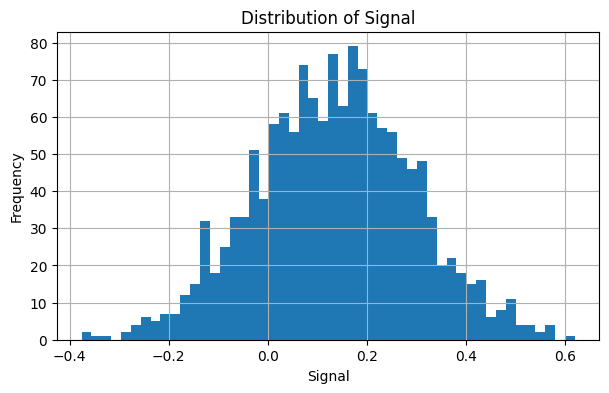

In [4]:
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

In [5]:
# Signal smoothing
df['signal'] = df['signal'].ewm(span=3).mean()
# df['signal'] = df['signal'].rolling(window=3).mean()


Overall Annual Return: 25.81%
Overall Annual Sharpe Ratio: 2.2366
Maximum Drawdown: -7.38 %
Win/Loss Ratio: 1.1026
Alpha: 0.2206
Beta: 0.1199

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.620112    0.156134     0.118068      0.520205       3.971660
1  2022      -0.008505    0.074677     0.040545      0.026386      -0.113892
2  2023       0.168587    0.091787     0.155191      0.003487       1.836716
3  2024       0.252239    0.120070     0.203405      0.067442       2.100760


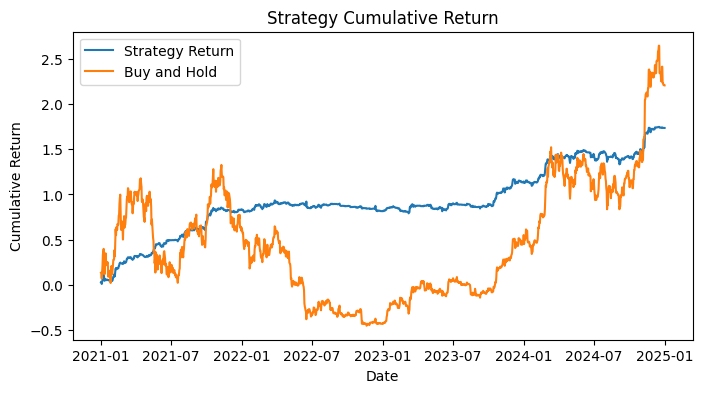

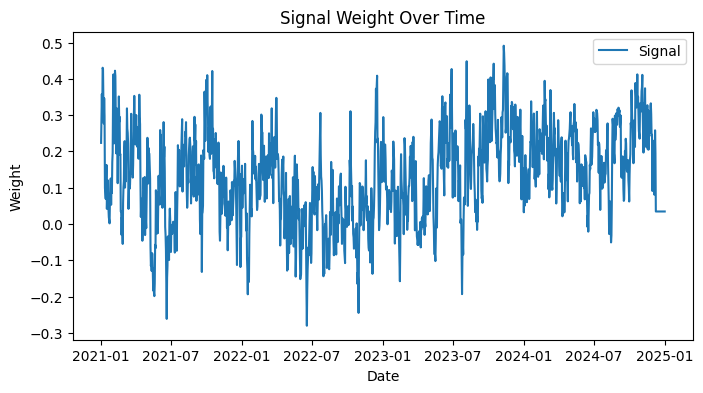

In [6]:
run_backtest(df)

Overall Annual Return: 25.22%
Overall Annual Sharpe Ratio: 2.1008
Maximum Drawdown: -6.36 %
Win/Loss Ratio: 1.1361
Alpha: 0.0698
Beta: 0.2034

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.252239     0.12007     0.203405      0.067442        2.10076


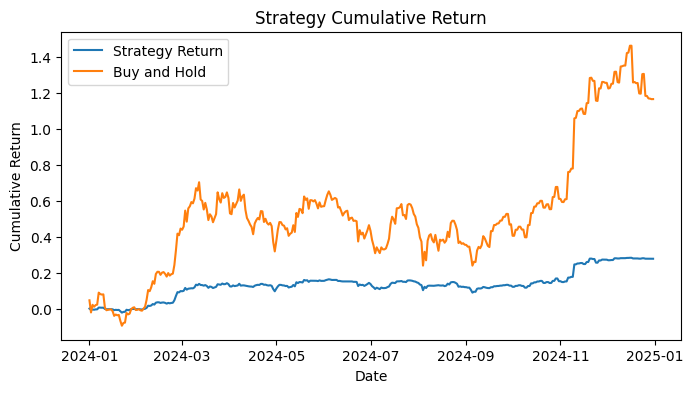

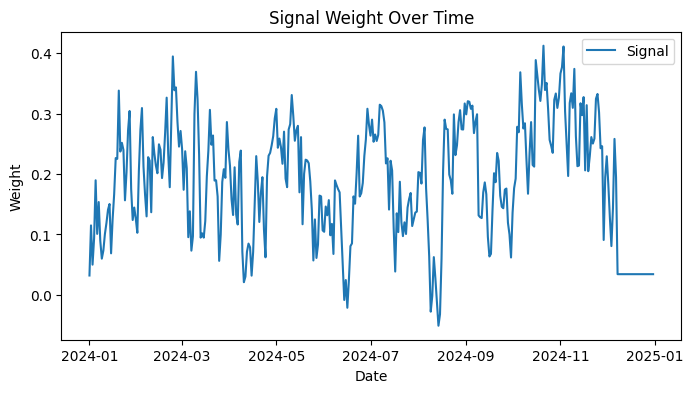

In [7]:
# backtest 2024 only
df = df[df.index.year == 2024]

run_backtest(df)

### strategy 2: random forest classifier

In [8]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.133747
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,-0.008069
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.048455
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.073631
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.056172


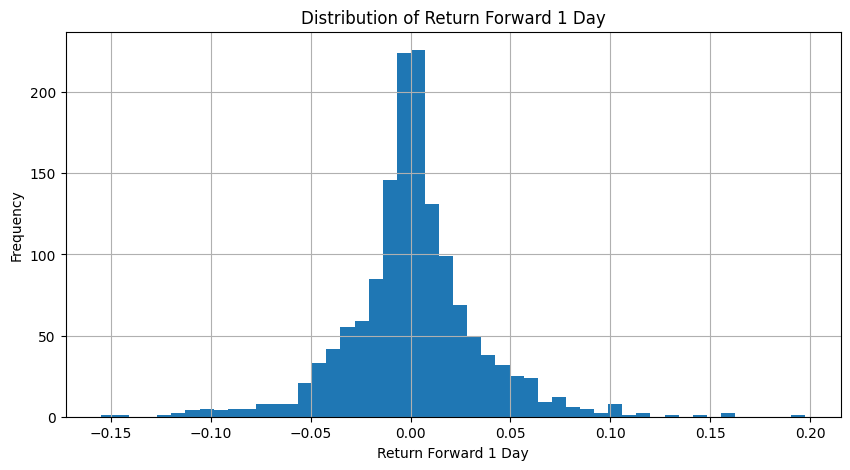

In [9]:
# plot return distribution
df['return_forward'].hist(bins=50, figsize=(10, 5))
plt.title('Distribution of Return Forward 1 Day')
plt.xlabel('Return Forward 1 Day')
plt.ylabel('Frequency')
plt.show()

In [10]:
# classify the return into 3 classes

df['signal'] = 0
df.loc[df['return_forward'] > 0.01, 'signal'] = 1
df.loc[df['return_forward'] < -0.01, 'signal'] = -1

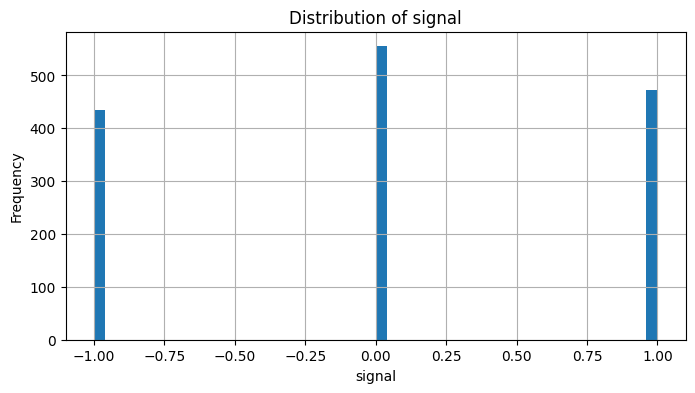

In [11]:
# plot signal distribution
df['signal'].hist(bins=50, figsize=(8, 4))
plt.title('Distribution of signal')
plt.xlabel('signal')
plt.ylabel('Frequency')
plt.show()

In [12]:
# split the dataset into 7:3
train_size = int(len(df) * 0.7)
test_size = int(len(df) * 0.3)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

signal_columns = ['tanalysis_absa', 'economy_absa', 
                  'regulation_absa', 'technology_absa', 
                  'adoption_absa', 'cybersecurity_absa']

# Check dataset sizes
print(f"Training set size: {train_df.shape[0]}")
print(train_df.groupby(train_df.index.year).size(), '\n')

print(f"Test set size: {test_df.shape[0]}")
print(test_df.groupby(test_df.index.year).size(), '\n')

# split to X and y
X_train = train_df[signal_columns].fillna(method='ffill').fillna(method='bfill')
y_train = train_df['signal']

X_test = test_df[signal_columns].fillna(method='ffill').fillna(method='bfill')
y_test = test_df['signal']

Training set size: 1022
2021    365
2022    365
2023    292
dtype: int64 

Test set size: 439
2023     73
2024    366
dtype: int64 



Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.3554


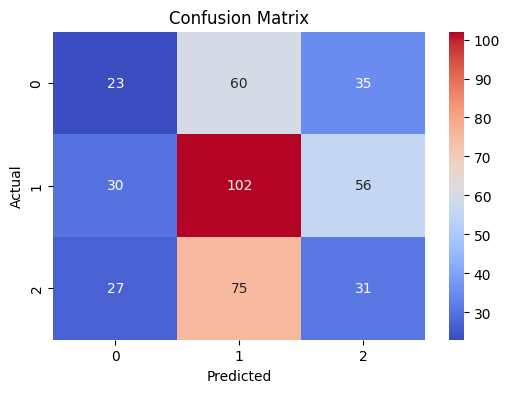

Classification Report:
               precision    recall  f1-score   support

          -1       0.29      0.19      0.23       118
           0       0.43      0.54      0.48       188
           1       0.25      0.23      0.24       133

    accuracy                           0.36       439
   macro avg       0.32      0.32      0.32       439
weighted avg       0.34      0.36      0.34       439



In [13]:
# Random Forest Classifier

# Hyperparameter Grid
param_grid = {
  'n_estimators': [50, 100, 200],
  'max_depth': [10, 20, 30],
  'min_samples_split': [2, 5, 10],
  'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
  estimator=rf,
  param_grid=param_grid,
  cv=5,
  n_jobs=-1,
  scoring='accuracy',
  verbose=1
)

# Train the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Initialize the best estimator
best_rf = grid_search.best_estimator_

# Predict on Test Set
y_pred = best_rf.predict(X_test)

# Evaluation Metrics
accuracy = best_rf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Overall Annual Return: -15.54%
Overall Annual Sharpe Ratio: -0.502
Maximum Drawdown: -41.87 %
Win/Loss Ratio: 0.9223
Alpha: -0.1457
Beta: 0.0019

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023       0.541286    0.258400     0.240543      0.065518       2.094762
1  2024      -0.294372    0.318629    -0.030404     -0.266750      -0.923872


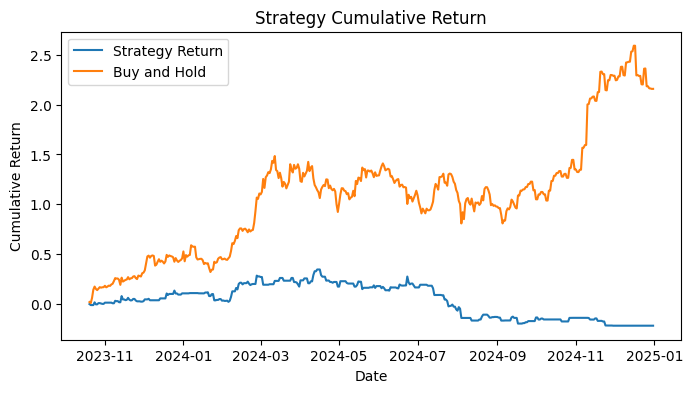

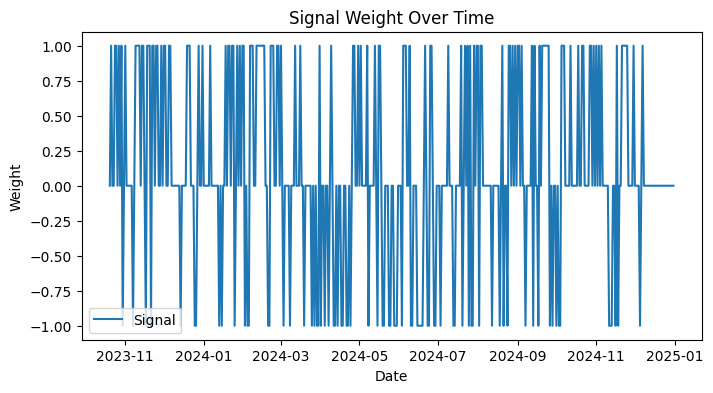

In [14]:
test_df['signal'] = y_pred
run_backtest(test_df)

### strategy 3: investigate each feature

In [15]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.133747
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,-0.008069
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.048455
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.073631
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.056172


In [16]:
df.columns

Index(['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa',
       'return_forward'],
      dtype='object')

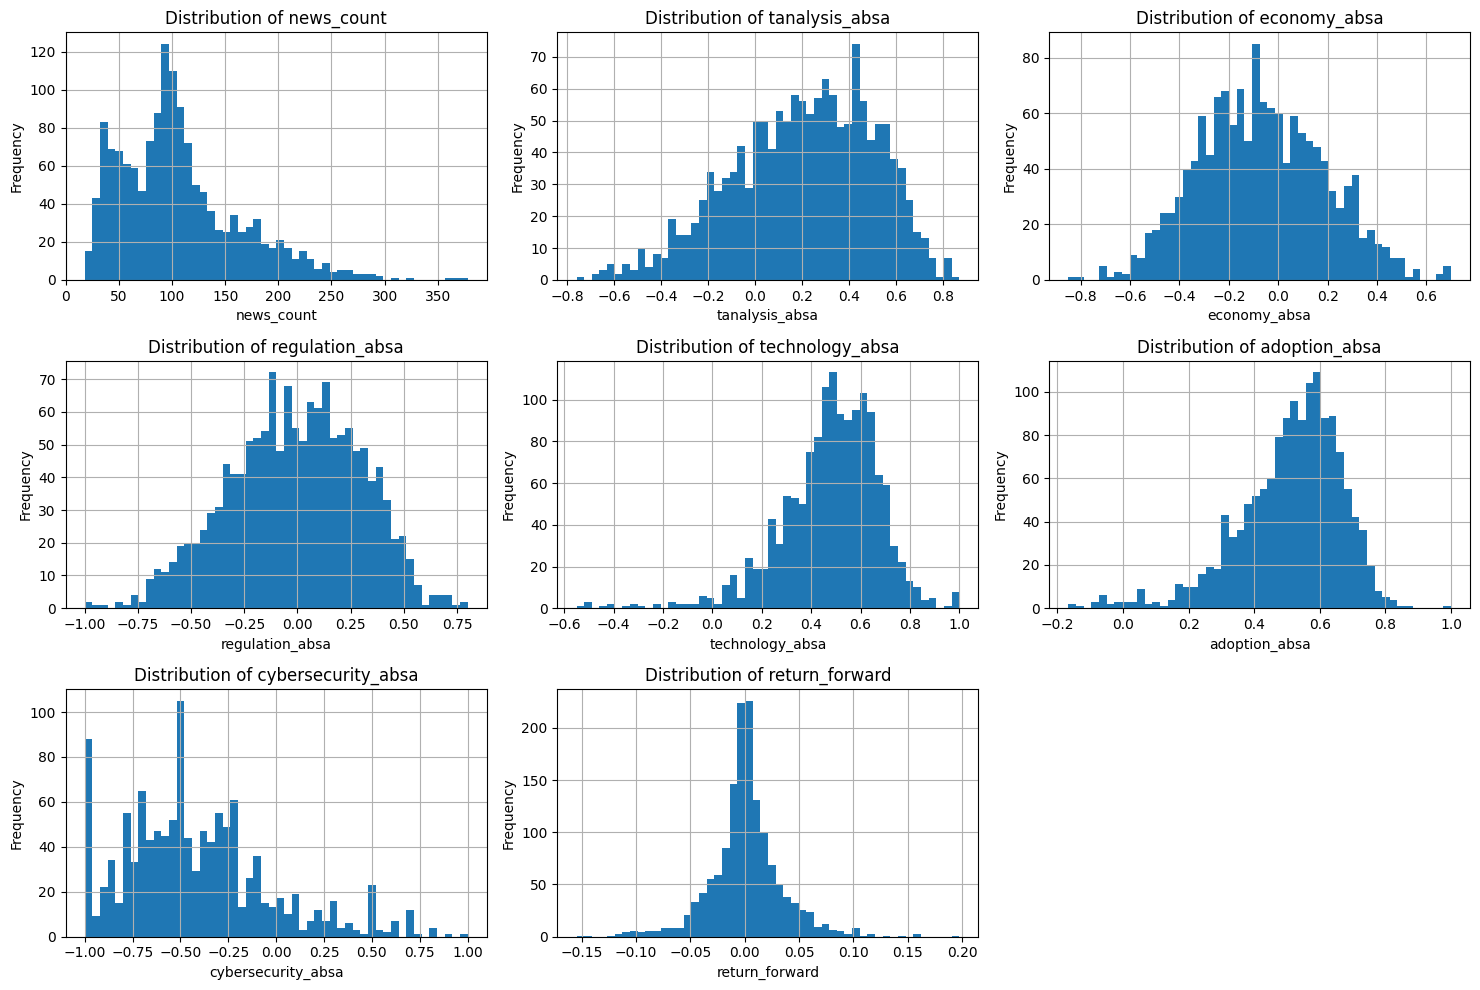

In [17]:
# plot the distribution of the columns
columns = ['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa', 'return_forward']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(columns):
  df[column].hist(ax=axes[i], bins=50)
  axes[i].set_title(f'Distribution of {column}')
  axes[i].set_xlabel(column)
  axes[i].set_ylabel('Frequency')

# Remove empty subplots
for j in range(len(columns), len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

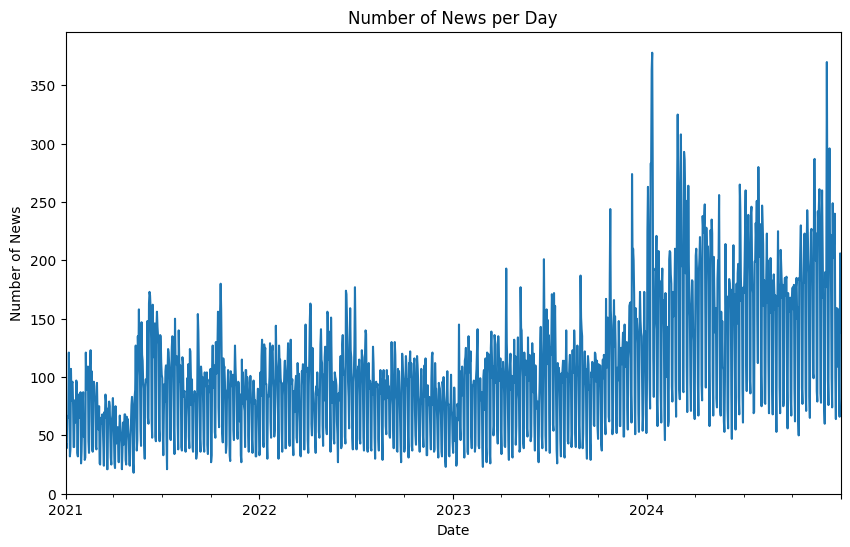

In [18]:
df['news_count'].plot(kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Number of News')
plt.title('Number of News per Day')
plt.show()

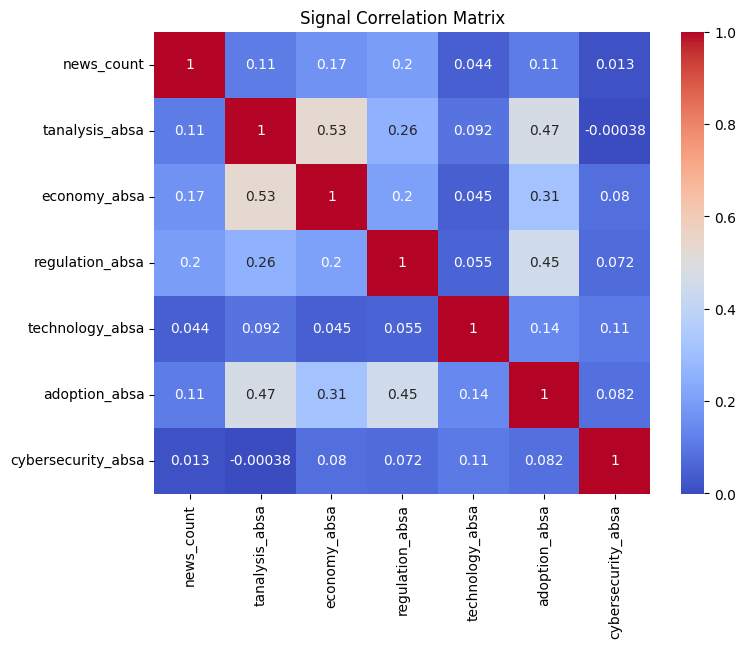

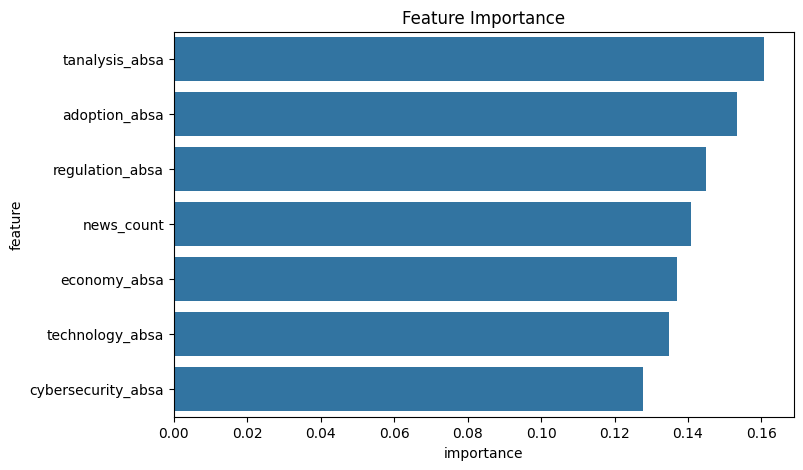


Statistical Analysis:
              feature    f_score       p_value
1      tanalysis_absa  32.980081  1.131157e-08
5       adoption_absa  13.013748  3.196454e-04
2        economy_absa   9.559752  2.026578e-03
4     technology_absa   5.531121  1.881346e-02
3     regulation_absa   0.268901  6.041484e-01
6  cybersecurity_absa   0.081146  7.757901e-01
0          news_count   0.079157  7.784834e-01


In [19]:
def analyze_features(df, signal_columns):
  # 1. Correlation Analysis
  correlation_matrix = df[signal_columns].corr()
  plt.figure(figsize=(8, 6))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
  plt.title('Signal Correlation Matrix')
  plt.show()
  
  # 2. Feature Importance using Random Forest
  X = df[signal_columns].fillna(method='ffill').fillna(method='bfill') # Forward fill then backward fill
  y = df['return_forward']
  rf = RandomForestRegressor(n_estimators=100, random_state=42)
  rf.fit(X, y)
  
  importance_df = pd.DataFrame({
      'feature': signal_columns,
      'importance': rf.feature_importances_
  }).sort_values('importance', ascending=False)
  
  plt.figure(figsize=(8, 5))
  sns.barplot(data=importance_df, x='importance', y='feature')
  plt.title('Feature Importance')
  plt.show()
  
  # 3. Statistical Analysis
  f_scores, p_values = f_regression(X, y)
  stats_df = pd.DataFrame({
    'feature': signal_columns,
    'f_score': f_scores,
    'p_value': p_values
  }).sort_values('f_score', ascending=False)
  
  print("\nStatistical Analysis:")
  print(stats_df)
  
  return correlation_matrix, importance_df, stats_df

signal_columns = ['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
corr_matrix, importance, stats = analyze_features(df, signal_columns)

Overall Annual Return: 59.85%
Overall Annual Sharpe Ratio: 2.9897
Maximum Drawdown: -12.58 %
Win/Loss Ratio: 1.2558
Alpha: 0.6647
Beta: 0.1807

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       1.298804    0.280726     0.213281      1.118328       4.626587
1  2022       0.279678    0.136312    -0.018153      0.264056       2.051744
2  2023       0.397794    0.157459     0.272024      0.108401       2.526329
3  2024       0.418196    0.191380     0.295590      0.149647       2.185156


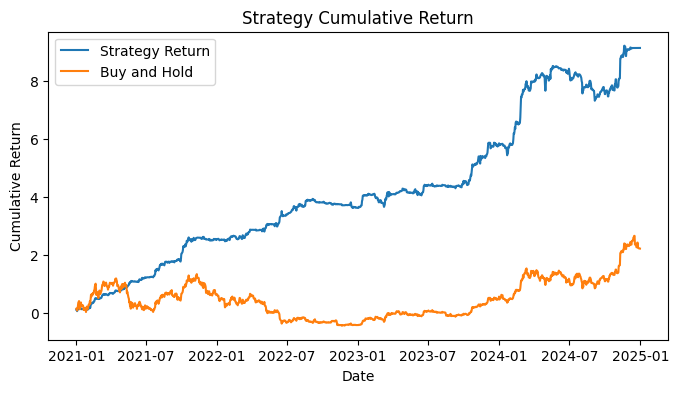

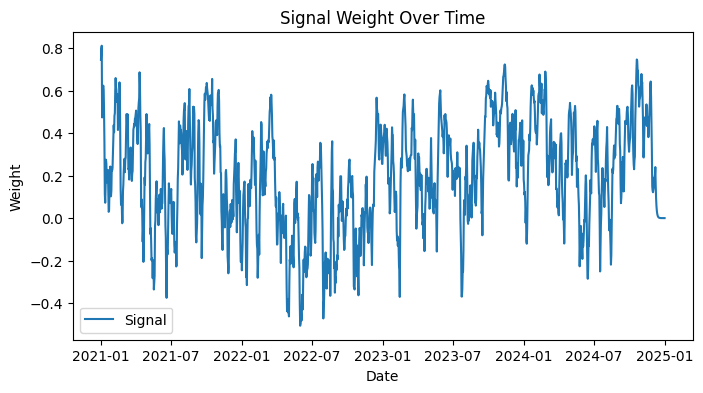

In [20]:
# backtest tanalysis_absa as signal
df['signal'] = df['tanalysis_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=4).mean() # 4 days ewm gives the best result
run_backtest(df)

Overall Annual Return: 16.73%
Overall Annual Sharpe Ratio: 1.4365
Maximum Drawdown: -12.87 %
Win/Loss Ratio: 1.0845
Alpha: 0.2167
Beta: -0.0589

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.315266    0.129464    -0.001583      0.316606       2.435174
1  2022       0.289461    0.167342    -0.251606      0.072944       1.729755
2  2023      -0.016642    0.068789    -0.067193      0.054841      -0.241925
3  2024       0.081438    0.068502     0.063958      0.023331       1.188844


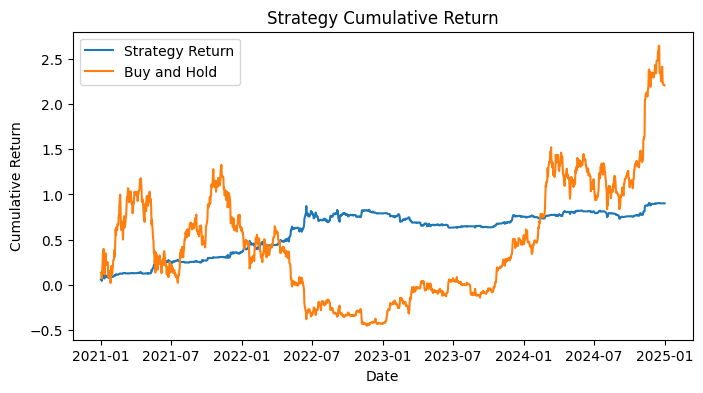

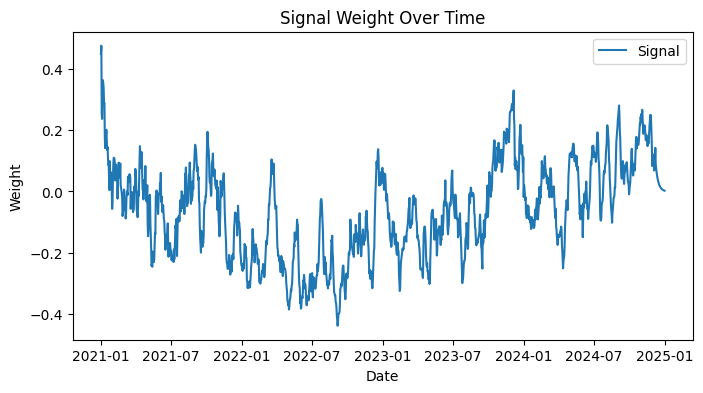

In [21]:
# backtest economy_absa as signal
df['signal'] = df['economy_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=13).mean() # 13 days ewm gives the best result
run_backtest(df)

Overall Annual Return: 5.87%
Overall Annual Sharpe Ratio: 0.3181
Maximum Drawdown: -28.54 %
Win/Loss Ratio: 1.0265
Alpha: 0.1061
Beta: -0.086

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.067928    0.276677    -0.183051      0.222823       0.245513
1  2022       0.007727    0.153986    -0.071478     -0.053783       0.050177
2  2023      -0.073291    0.143825    -0.088258      0.020602      -0.509588
3  2024       0.232137    0.125059     0.141778      0.103329       1.856218


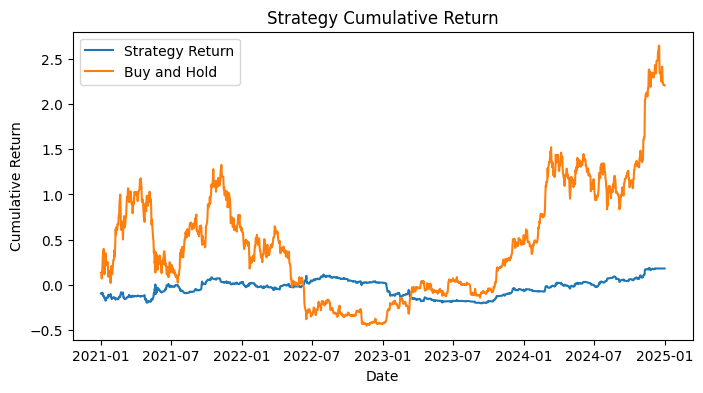

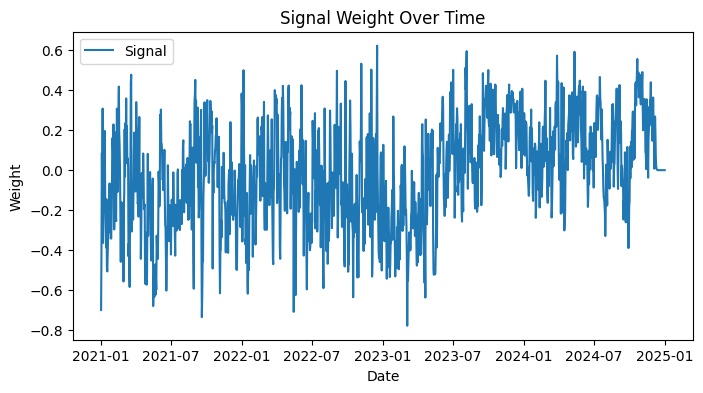

In [22]:
# backtest regulation_absa as signal
df['signal'] = df['regulation_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=2).mean()
run_backtest(df)

Overall Annual Return: 37.04%
Overall Annual Sharpe Ratio: 1.1844
Maximum Drawdown: -43.44 %
Win/Loss Ratio: 1.0837
Alpha: 0.1655
Beta: 0.4435

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.691719    0.376974     0.390790      0.361037       1.834923
1  2022      -0.410543    0.314853     0.452729     -0.020953      -1.303921
2  2023       0.596239    0.270366     0.545009      0.016430       2.205300
3  2024       0.603427    0.274650     0.483111      0.164512       2.197073


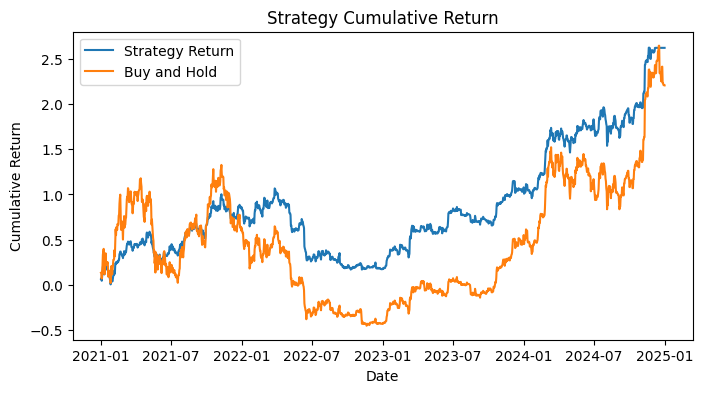

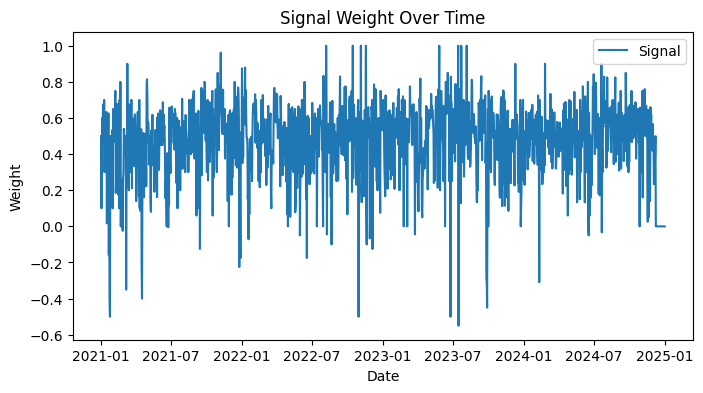

In [23]:
# backtest technology_absa as signal
df['signal'] = df['technology_absa']
df['signal'] = df['signal'].fillna(0)
# no ewm gives the best result
run_backtest(df)

Overall Annual Return: 44.52%
Overall Annual Sharpe Ratio: 1.3346
Maximum Drawdown: -43.65 %
Win/Loss Ratio: 1.1074
Alpha: 0.2247
Beta: 0.4951

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       1.016521    0.465701     0.519232      0.577154       2.182776
1  2022      -0.307505    0.289846     0.427631      0.060488      -1.060926
2  2023       0.527314    0.243842     0.503432     -0.008263       2.162523
3  2024       0.544256    0.288642     0.517637      0.073975       1.885574


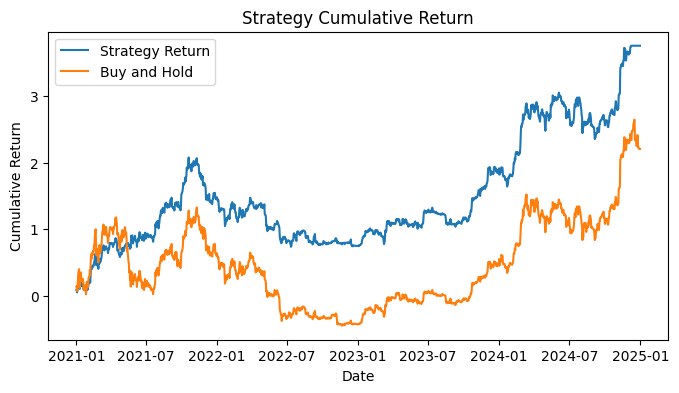

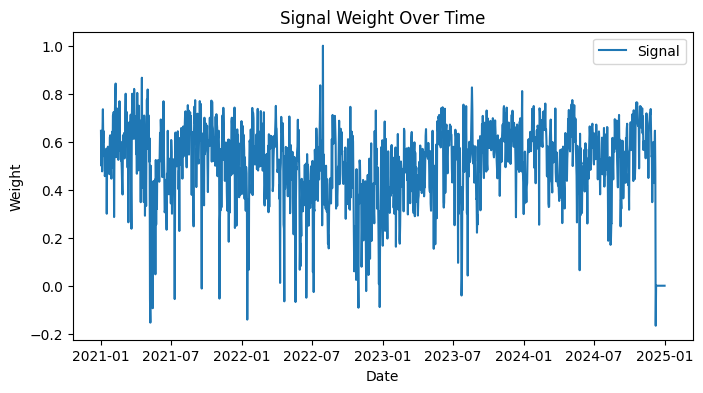

In [24]:
# backtest adoption_absa as signal
df['signal'] = df['adoption_absa']
df['signal'] = df['signal'].fillna(0)
# no ewm gives the best result
run_backtest(df)

Overall Annual Return: -23.34%
Overall Annual Sharpe Ratio: -0.7328
Maximum Drawdown: -69.08 %
Win/Loss Ratio: 0.9381
Alpha: -0.0945
Beta: -0.2739

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021      -0.072848    0.415996    -0.277064      0.161600      -0.175118
1  2022      -0.116625    0.313749    -0.314715     -0.387450      -0.371716
2  2023      -0.455227    0.274196    -0.192608     -0.250320      -1.660221
3  2024      -0.288626    0.244358    -0.278414     -0.035682      -1.181161


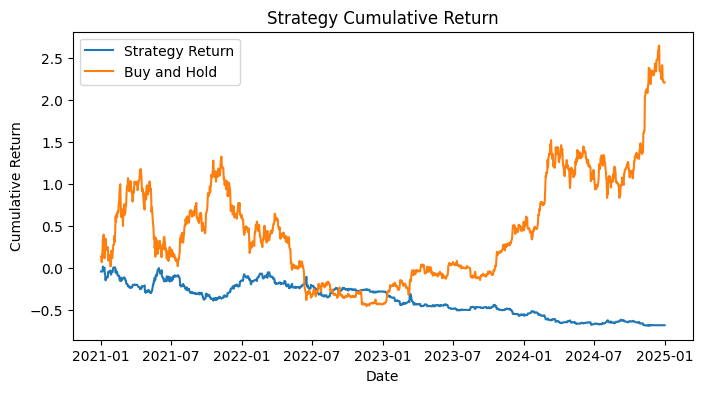

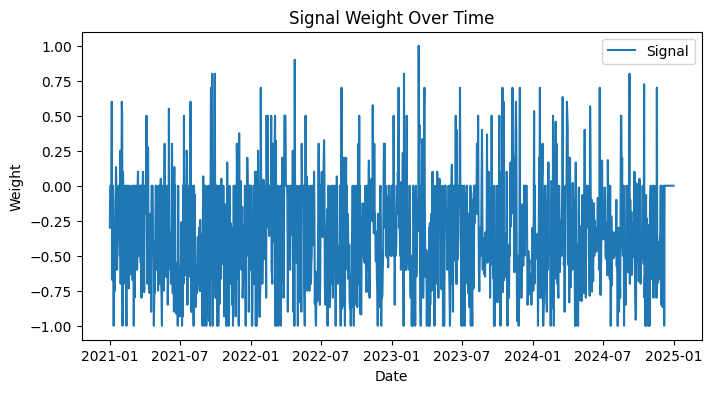

In [25]:
# backtest cybersecurity_absa as signal
df['signal'] = df['cybersecurity_absa']
df['signal'] = df['signal'].fillna(0)
# no ewm gives the best result
run_backtest(df)

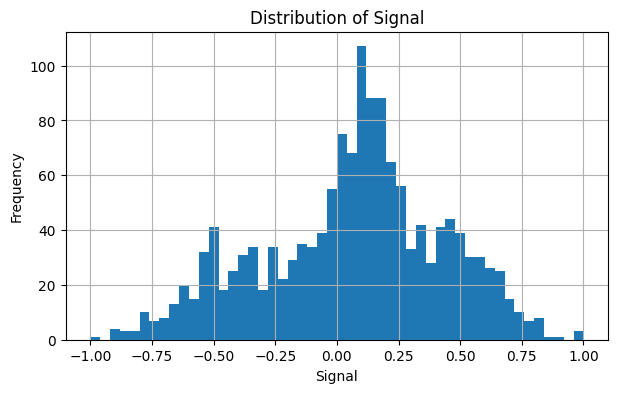

Overall Annual Return: 5.52%
Overall Annual Sharpe Ratio: 0.2271
Maximum Drawdown: -39.42 %
Win/Loss Ratio: 1.0815
Alpha: 0.0619
Beta: -0.0098

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021      -0.061113    0.323044    -0.169381      0.082215      -0.189179
1  2022      -0.074404    0.169787     0.001494     -0.073118      -0.438218
2  2023       0.122098    0.183912    -0.009146      0.131828       0.663893
3  2024       0.233785    0.263967     0.380442     -0.111853       0.885659


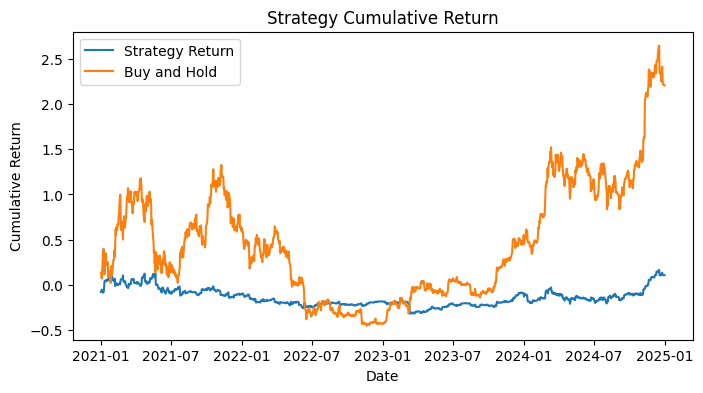

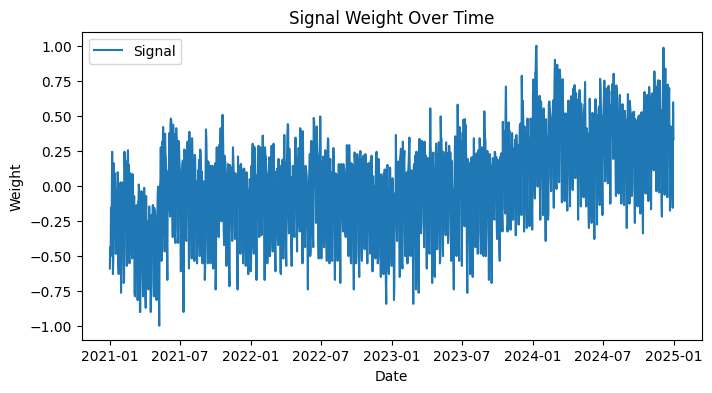

In [26]:
# backtest news_count as signal
df['signal'] = df['news_count']
df['signal'] = df['signal'].fillna(0)

# feature scaling, right skewed, log transformation
df['signal'] = np.log1p(df['signal'])

# scale the signal to be between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

# plot the distribution of the signal
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

run_backtest(df)


### strategy 4: improved random forest classifer

In [27]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.133747
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,-0.008069
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.048455
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.073631
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.056172


In [28]:
df = df.fillna(0)

# apply ewm (based on previous analysis)
df['tanalysis_absa'] = df['tanalysis_absa'].ewm(span=4).mean()
df['economy_absa'] = df['economy_absa'].ewm(span=13).mean()
df['regulation_absa'] = df['regulation_absa'].ewm(span=2).mean()

# remove insignificant features (based on previous analysis)
df.drop(columns=['news_count', 'cybersecurity_absa'], inplace=True)

In [29]:
df.head()

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,return_forward
2021-01-01,0.744828,0.450000,-0.700000,0.5,0.645455,0.133747
2021-01-02,0.796498,0.476923,-0.400000,0.1,0.500000,-0.008069
2021-01-03,0.810653,0.254331,0.084615,0.4,0.616667,-0.048455
2021-01-04,0.473519,0.237466,-0.130000,0.6,0.476471,0.073631
2021-01-05,0.519703,0.326254,0.308471,0.5,0.650000,0.056172


In [30]:
df['signal'] = 0
df.loc[df['return_forward'] > 0.01, 'signal'] = 1
df.loc[df['return_forward'] < -0.01, 'signal'] = -1

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.3394


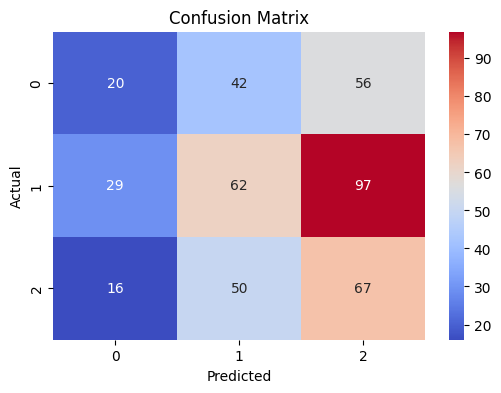

Classification Report:
               precision    recall  f1-score   support

          -1       0.31      0.17      0.22       118
           0       0.40      0.33      0.36       188
           1       0.30      0.50      0.38       133

    accuracy                           0.34       439
   macro avg       0.34      0.33      0.32       439
weighted avg       0.35      0.34      0.33       439



In [31]:
# split dataset to 7:3
train_size = int(len(df) * 0.7)
test_size = int(len(df) * 0.3)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# split to X and y
X_train = train_df[['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa']]
y_train = train_df['signal']
X_test = test_df[['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa']]
y_test = test_df['signal']

# Random Forest Regressor

# Hyperparameter Grid
param_grid = {
  'n_estimators': [50, 100, 200],
  'max_depth': [10, 20, 30],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [2, 4, 6],
  'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
  estimator=rf,
  param_grid=param_grid,
  cv=5,
  n_jobs=-1,
  scoring='accuracy',
  verbose=1
)

# Train the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Initialize the best estimator
best_rf = grid_search.best_estimator_

# Predict on Test Set
y_pred = best_rf.predict(X_test)

# Evaluation Metrics
accuracy = best_rf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Overall Annual Return: 68.21%
Overall Annual Sharpe Ratio: 1.5664
Maximum Drawdown: -41.3 %
Win/Loss Ratio: 1.1953
Alpha: 0.3422
Beta: 0.3569

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023       0.955827    0.343684     0.582590     -0.196475       2.781122
1  2024       0.627527    0.451889     0.327854      0.329666       1.388677


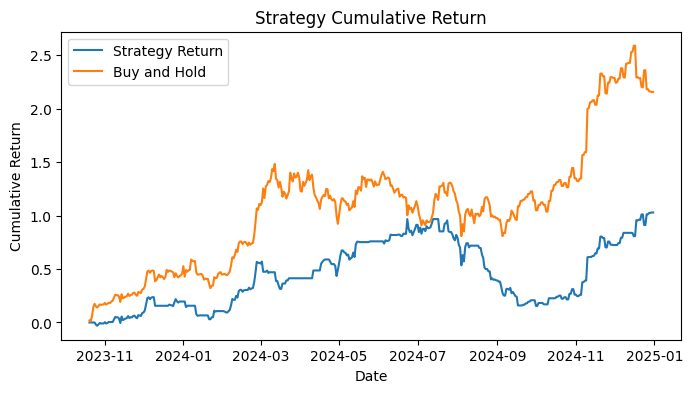

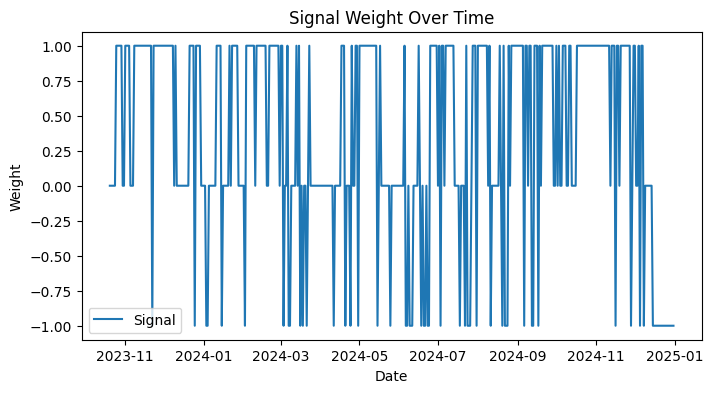

In [32]:
test_df['signal'] = y_pred
run_backtest(test_df)

### Strategy 5: manually optimized ABSA

In [33]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.133747
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,-0.008069
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.048455
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.073631
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.056172


Overall Annual Return: 79.58%
Overall Annual Sharpe Ratio: 3.1655
Maximum Drawdown: -14.77 %
Win/Loss Ratio: 1.2419
Alpha: 1.1682
Beta: 0.0431

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       1.777100    0.336161     0.092582      1.698758       5.286452
1  2022       0.623960    0.260811    -0.258971      0.401106       2.392388
2  2023       0.358086    0.164562     0.181814      0.164663       2.175988
3  2024       0.425019    0.204070     0.217610      0.227317       2.082713


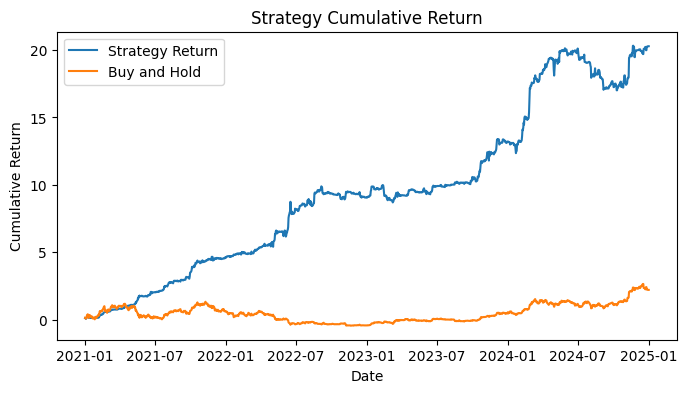

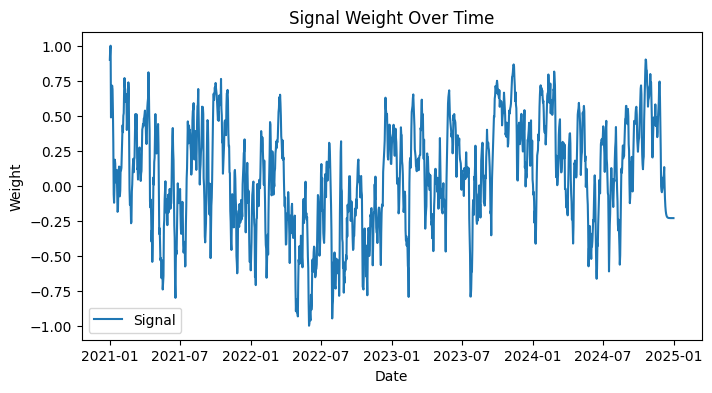

In [34]:
df = df.fillna(0)

# apply ewm (based on previous analysis)
df['tanalysis_absa'] = df['tanalysis_absa'].ewm(span=4).mean()

df['signal'] = df['tanalysis_absa']

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 42.5%
Overall Annual Sharpe Ratio: 2.0827
Maximum Drawdown: -14.77 %
Win/Loss Ratio: 1.1879
Alpha: 0.2551
Beta: 0.2176

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.425019     0.20407      0.21761      0.227317       2.082713


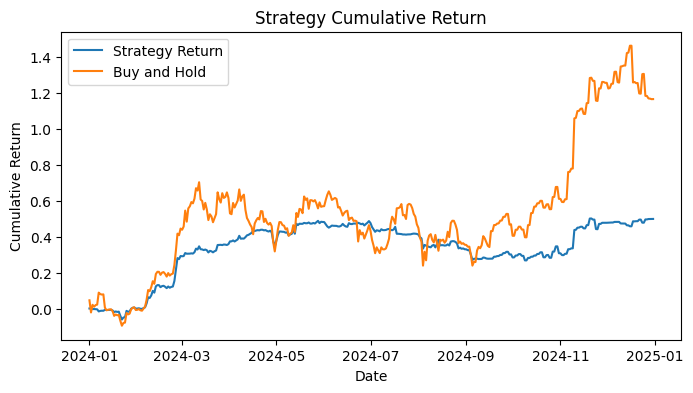

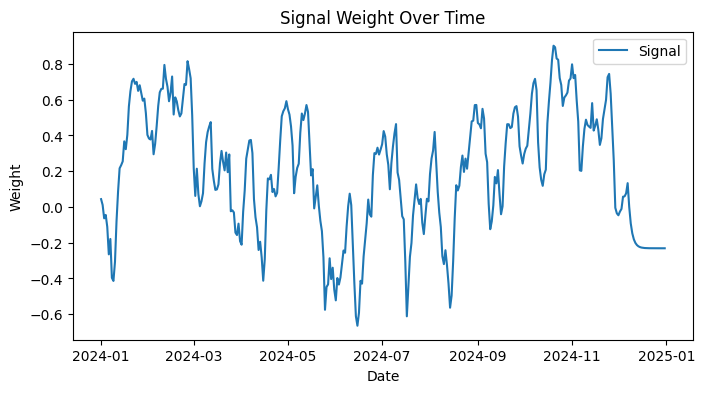

In [35]:
# backtest 2024 only
df = df[df.index.year == 2024]

run_backtest(df)